In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, Reshape, AveragePooling2D
from keras.layers import Input, Bidirectional, GlobalMaxPool1D, LSTM
from keras.applications.densenet import DenseNet121, preprocess_input
from keras import Input
from keras.initializers import he_normal
from keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
from PIL import Image
from tensorflow.keras.optimizers import Adam, RMSprop
from shutil import rmtree, copyfile
from itertools import cycle
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, average_precision_score, f1_score
import seaborn as sb
import tensorflow as tf
import matplotlib.cm as cm
import re
from tensorflow.keras.utils import Sequence

# Project variables

In [2]:
m_name = "combo model v3_channel"
p_dir = os.path.join("../combo models", m_name)

In [3]:
def create_dir(dir_path: str):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

In [4]:
def clear_dir(dir_path: str):
    for item in os.listdir(dir_path):
        fp = os.path.join(dir_path, item)
        if os.path.isfile(fp):
            os.remove(fp)
        if os.path.isdir(fp):
            rmtree(fp)

In [168]:
create_dir(p_dir)
clear_dir(p_dir)

# Read and transform scraped dataframes

In [28]:
fp = "../scraped data"

channels = pd.read_pickle(os.path.join(fp, "channels.pkl"))
videos = pd.read_pickle(os.path.join(fp, "videos.pkl"))

In [29]:
def transform_channels(df: pd.DataFrame) -> pd.DataFrame:
    # Date string into proper date
    df.published = pd.to_datetime(df.published)
    
    # Convert field type into int64
    fields = ["video_count", "view_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("int64")
    
    # Convert field type into float64
    fields = ["subscriber_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("float64")
    
    # Add of channel in months
    df["age_mth"] = (pd.to_datetime("today", utc=True).year - df.published.dt.year) * 12 \
        + (pd.to_datetime("today", utc=True).month - df.published.dt.month)
        
    # Drop unnecessary fields
    df.drop(columns=["custom_url", "country"] + [c for c in df.columns if c.startswith("thumbnail")], inplace=True)
    
    # Remove channels without subscriber_count
    df = df.loc[df.subscriber_count.notnull(), :]
    
    # Remove Simplilearn
    df = df.loc[df["title"] != "Simplilearn", :]
    
    return df

In [30]:
def transform_videos(df: pd.DataFrame) -> pd.DataFrame:    
    # Date string into proper date
    df.published = pd.to_datetime(df.published)
    
    # Convert field type to bool
    fields = ["broadcast"]
    df.loc[:, fields] = df.loc[:, fields].astype("bool")
    
    # Convert field type into int64
    fields = ["category_id"]
    df.loc[:, fields] = df.loc[:, fields].astype("int64")
    
    # Convert field type into float64
    fields = ["comment_count", "dislike_count", "like_count", "view_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("float64")
    
    df["published_mth"] = (pd.to_datetime("today", utc=True).year - df.published.dt.year) * 12 \
        + (pd.to_datetime("today", utc=True).month - df.published.dt.month)
    df["title_len"] = df.title.str.len()
    
    df.drop(columns=["favorite_count", "broadcast", "audio_language", "comment_count", "category_id"] \
            + [c for c in df.columns if c.startswith("thumbnail")], inplace=True)
    
    df = df.loc[df.like_count.notnull() & df.dislike_count.notnull() & df.view_count.notnull(), :]
    
    return df

In [31]:
channels_trans = transform_channels(channels)
videos_trans = transform_videos(videos)
combo = videos_trans.merge(channels_trans[["id", "view_count","published", "age_mth", "subscriber_count",
                                             "video_count"]], 
                           how="inner", left_on="channel_id", right_on="id", suffixes=["_video", "_channel"])
combo["ln_vc_norm"] = np.log(combo.view_count_video / combo.subscriber_count)
combo.shape

(16300, 17)

# Define categories

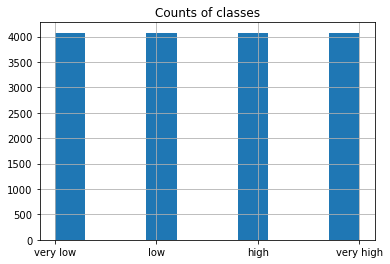

In [32]:
cat_lbl = ["very low", "low", "high", "very high"]
combo.loc[:, "qtl"] = pd.qcut(combo.ln_vc_norm, len(cat_lbl), labels=cat_lbl, precision=6)
combo.sort_values(by=["qtl"]).qtl.hist()
plt.title("Counts of classes")
plt.show()

In [33]:
excl_channels = ["TED-Ed", "SciShow", "Quanta Magazine", "Fermilab", "The Science Asylum", "BrainCraft", "It's Okay To Be Smart", "Physics Videos by Eugene Khutoryansky"]
combo_excl = combo.loc[combo["channel_name"].isin(excl_channels), :]
combo = combo.loc[~combo["channel_name"].isin(excl_channels), :]
combo.shape

(10328, 18)

In [34]:
combo.to_pickle(os.path.join(p_dir, "combo.pkl"))
combo_excl.to_pickle(os.path.join(p_dir, "combo_excl.pkl"))
combo_excl.shape

(5972, 18)

# Split dataset (use only top and bottom quartile data)

In [35]:
cat_lbl = ["very low", "very high"]
combo2 = combo.loc[~combo.qtl.isin(cat_lbl)] 
combo = combo.loc[combo.qtl.isin(cat_lbl)]
combo.qtl = combo.qtl.cat.remove_unused_categories()

y = combo.qtl
x = combo.loc[:, [c for c in combo.columns if c != "qtl"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=4711)

x_train.to_pickle(os.path.join(p_dir, "x_train.pkl"))
y_train.to_pickle(os.path.join(p_dir, "y_train.pkl"))
x_val.to_pickle(os.path.join(p_dir,"x_val.pkl"))
y_val.to_pickle(os.path.join(p_dir, "y_val.pkl"))
x_test.to_pickle(os.path.join(p_dir,"x_test.pkl"))
y_test.to_pickle(os.path.join(p_dir, "y_test.pkl"))

print(x_train.shape[0], x_val.shape[0], x_test.shape[0])

3357 1119 1119


In [36]:
combo.shape

(5595, 18)

In [37]:
combo2.shape

(4733, 18)

# Build the model

In [15]:
def create_img_model():
    
    inp = Input(shape=(180, 320, 3))
    
    base_model = DenseNet121(weights="imagenet", include_top=False, input_tensor=inp)
    base_model.trainable = False
    x = base_model.output
    
    x = AveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    out = Dense(len(cat_lbl), activation="sigmoid")(x)
    
    model = Model(base_model.input, out)
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=0.0005), 
                  metrics=["accuracy"])
    
    return model

In [16]:
pt_model = "roberta-base"

In [17]:
def create_nlp_model():
    
    # config = RobertaConfig(dropout=0.2, attention_dropout=0.2)
    # config.output_hidden_states=False
    transformer_model = TFRobertaModel.from_pretrained(pt_model)

    in_ids = Input(shape=(100,), name="input_token", dtype="int32")
    in_masks = Input(shape=(100,), name="masked_token", dtype="int32")

    emb = transformer_model(in_ids, attention_mask=in_masks)[0]
    x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0))(emb)
    x = GlobalMaxPool1D()(x)
    x = Flatten()(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(2, activation="softmax")(x)
    model = Model(inputs=[in_ids, in_masks], outputs=x)
        
    return model

In [18]:
def create_model():
    
    # Load image model with weights and remove last layer
    m_name = "densenet_2_classes_bce_fmt2_channel"
    img_model = create_img_model()
    img_model.load_weights("../img models/{a}/{a}".format(a=m_name))
    for layer in img_model.layers:
        layer.trainable = False
    
    # Load nlp model with weights and remove last layer
    m_name = "roberta_2_classes_channel"
    nlp_model = create_nlp_model()
    nlp_model.load_weights("../nlp models/{a}/{a}".format(a=m_name))
    for layer in nlp_model.layers:
        layer.trainable = False
    
    m1 = img_model.layers[-4].output
    m1 = Dense(50, activation="relu")(m1)
    m1 = BatchNormalization()(m1)
    m2 = nlp_model.layers[-3].output
    # m2 = BatchNormalization()(m2)
    x = Concatenate()([m1, m2])
    # x = BatchNormalization()(x)
    # x = Dropout(0.3)(x)
    # x = Dense(100, activation="relu")(x)
    # x = Dropout(0.5)(x)
    x = Dense(20, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(2, activation="softmax")(x)
    model = Model(inputs=[img_model.input, nlp_model.input[0], nlp_model.input[1]], outputs=x)
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.0005),
                  metrics=["accuracy"])
    
    return model    

In [19]:
model = create_model()

2021-12-29 12:07:08.841641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 12:07:08.851757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 12:07:08.852582: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 12:07:08.853801: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [184]:
# model.summary()

# Text preprocessing and tokenization

In [20]:
def preprocessing_sentence(txt: str, remove_stopwords: bool=False) -> str:
    field = "title"
    stw = set(stopwords.words("english"))
    
    def cleanse_row(txt, field, stw, stopwords=False):
        # Remove HTML from text
        soup = BeautifulSoup(txt)
        txt = soup.get_text()
        
        # Remove stopwords
        if stopwords:
            txt = " ".join([w for w in txt.split() if w not in stw])
        
        return txt
    
    txt = cleanse_row(txt, field, stw, remove_stopwords)
    return txt

In [21]:
# Download the stopwork corpus
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
remove_stopwords = False

def preprocess_sentences(x: pd.DataFrame, remove_stopwords: bool=False) -> list():
    x_pp = preprocessing_sentence(x, remove_stopwords)
    x_pp = x_pp.tolist()
    return x_pp

In [23]:
tok = RobertaTokenizer.from_pretrained(pt_model, do_lower=True, add_special_tokens=True, max_length=100, pad_to_max_length=True)

In [24]:
def tokenize(sentence, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    
    inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=100, padding="max_length", return_attention_mask=True, 
                                   return_token_type_ids=True, truncation=True)
    input_ids.append(inputs["input_ids"])
    input_masks.append(inputs["attention_mask"])
    input_segments.append(inputs["token_type_ids"])
        
    return np.asarray(input_ids, dtype="int32"), np.asarray(input_masks, dtype="int32"), np.asarray(input_segments, dtype="int32")

# Prepare DataGenerators

In [25]:
class TkDataGenerator(Sequence):
    def __init__(self, df, img_col, txt_col, y_col, img_dir, img_pp_func, txt_pp_func, tok_func, tokenizer, lb, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.img_pp_func = img_pp_func
        self.txt_pp_func = txt_pp_func
        self.tok_func = tok_func
        self.tokenizer = tokenizer
        self.lb = lb
        self.img_col = img_col
        self.txt_col = txt_col
        self.y_col = y_col
        self.lb = lb
        self.img_dir = img_dir
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        x1, x2, x3, y = self.__get_data(batch)
        return (x1, x2, x3), y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, batch):
        x1 = np.empty((self.batch_size, *(180, 320, 3)), dtype="float32")
        x2 = np.empty((self.batch_size, 100), dtype="int32")
        x3 = np.empty((self.batch_size, 100), dtype="int32")
        y = np.empty((self.batch_size, 2), dtype="float32")
        
        for i, i_df in enumerate(batch):
            img = load_img(os.path.join(img_dir, "{}.jpg".format(self.df.loc[i_df, self.img_col])), target_size=(180, 320))
            img = self.img_pp_func(np.array(img)).astype("float32")
            pp = self.txt_pp_func(self.df.loc[i_df, self.txt_col])
            t1, t2, t3 = self.tok_func(pp, self.tokenizer)
            
            x1[i] = img
            x2[i] = t1
            x3[i] = t2
            y[i] = np.array([int(l == self.df.loc[i_df, self.y_col]) for l in self.lb])
            
        return x1, x2, x3, y

In [26]:
def train_generator(X, y, img_dir, lb, batch_size):
    combo = pd.concat([X, y], axis="columns")
    combo["file_name"] = combo.id_video + ".jpg"
    datagen = TkDataGenerator(df=combo, 
                              img_col="id_video", 
                              txt_col="title",
                              y_col="qtl",
                              img_dir=img_dir, 
                              img_pp_func=preprocess_input, 
                              txt_pp_func=preprocessing_sentence, 
                              tok_func=tokenize,
                              tokenizer=tok, 
                              lb=lb,
                              batch_size=batch_size, 
                              shuffle=True)
    return datagen

def val_generator(X, y, img_dir, lb, batch_size):
    combo = pd.concat([X, y], axis="columns")
    combo["file_name"] = combo.id_video + ".jpg"
    datagen = TkDataGenerator(df=combo, 
                              img_col="id_video", 
                              txt_col="title",
                              y_col="qtl",
                              img_dir=img_dir, 
                              img_pp_func=preprocess_input, 
                              txt_pp_func=preprocessing_sentence, 
                              tok_func=tokenize,
                              tokenizer=tok, 
                              lb=lb,
                              batch_size=batch_size, 
                              shuffle=True)
    return datagen

def test_generator(X, y, img_dir, lb):
    combo = pd.concat([X, y], axis="columns")
    combo["file_name"] = combo.id_video + ".jpg"
    datagen = TkDataGenerator(df=combo, 
                              img_col="id_video", 
                              txt_col="title",
                              y_col="qtl",
                              img_dir=img_dir, 
                              img_pp_func=preprocess_input, 
                              txt_pp_func=preprocessing_sentence, 
                              tok_func=tokenize,
                              tokenizer=tok, 
                              lb=lb,
                              batch_size=1, 
                              shuffle=False)
    return datagen

# Train the model

In [192]:
img_dir = "../images_medium"
batch_size = 32

train_gen = train_generator(x_train, y_train, img_dir, cat_lbl, batch_size)
val_gen = val_generator(x_val, y_val, img_dir, cat_lbl, batch_size)

metric = "val_loss"

es = EarlyStopping(monitor=metric, 
                   mode="min", 
                   patience=5, 
                   restore_best_weights=True)

checkpoint = ModelCheckpoint(os.path.join(p_dir, "{}".format(m_name)), 
                             monitor=metric, 
                             verbose=2, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min')

hist = model.fit(train_gen,
                 epochs=200,
                 validation_data=val_gen,
                 verbose=1,
                 callbacks=[checkpoint, es])

Epoch 1/200
104/104 [==============================] - 69s 505ms/step - loss: 0.3886 - accuracy: 0.8287 - val_loss: 0.2300 - val_accuracy: 0.9118

Epoch 00001: val_loss improved from inf to 0.22996, saving model to ../combo models/combo model v3_channel/combo model v3_channel
Epoch 2/200
104/104 [==============================] - 47s 456ms/step - loss: 0.2918 - accuracy: 0.8825 - val_loss: 0.2129 - val_accuracy: 0.9127

Epoch 00002: val_loss improved from 0.22996 to 0.21288, saving model to ../combo models/combo model v3_channel/combo model v3_channel
Epoch 3/200
104/104 [==============================] - 47s 454ms/step - loss: 0.2732 - accuracy: 0.8915 - val_loss: 0.2009 - val_accuracy: 0.9246

Epoch 00003: val_loss improved from 0.21288 to 0.20086, saving model to ../combo models/combo model v3_channel/combo model v3_channel
Epoch 4/200
104/104 [==============================] - 47s 456ms/step - loss: 0.2476 - accuracy: 0.9035 - val_loss: 0.2059 - val_accuracy: 0.9191

Epoch 00004: v

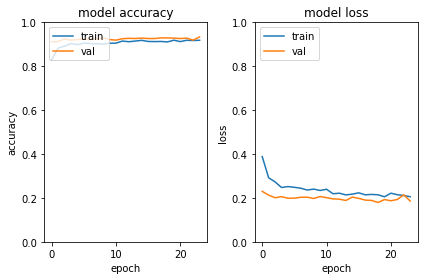

In [193]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(hist.history["accuracy"])
axs[0].plot(hist.history["val_accuracy"])
axs[0].set_title("model accuracy")
axs[0].set_ylabel("accuracy")
axs[0].set_xlabel("epoch")
axs[0].set_ylim(0, 1)
axs[0].legend(["train", "val"], loc="upper left")

axs[1].plot(hist.history["loss"])
axs[1].plot(hist.history["val_loss"])
axs[1].set_title("model loss")
axs[1].set_ylabel("loss")
axs[1].set_xlabel("epoch")
axs[1].set_ylim(0, 1)
axs[1].legend(["train", "val"], loc="upper left")

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(p_dir, "accuracy_loss.jpg"))

# Sample images per category

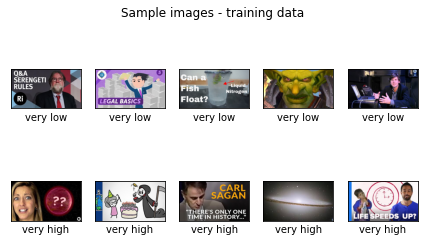

In [194]:
s = combo.loc[combo["id_video"].isin(x_train["id_video"]), ["id_video", "qtl"]].groupby("qtl", as_index=False).apply(lambda x: x.sample(5, random_state=15))

n_images = 5
fig, axs = plt.subplots(len(cat_lbl), n_images)
i = 0

for idx, row in s.iterrows():
    img = Image.open(os.path.join(img_dir, "{}.jpg".format(row["id_video"])))
    axs[i // n_images, i % n_images].imshow(img)
    axs[i // n_images, i % n_images].xaxis.set_ticklabels([])
    axs[i // n_images, i % n_images].xaxis.set_ticks([])
    axs[i // n_images, i % n_images].set_xlabel(row["qtl"])
    axs[i // n_images, i % n_images].yaxis.set_ticklabels([])
    axs[i // n_images, i % n_images].yaxis.set_ticks([])
    i += 1
plt.tight_layout()
plt.suptitle("Sample images - training data")
plt.show()
fig.savefig(os.path.join(p_dir, "sample_images.jpg"))

# Confusion matrix

In [27]:
# model = load_model(os.path.join(p_dir, "{}".format(m_name)))
model.load_weights(os.path.join(p_dir, "{}".format(m_name)))

## Training dataset (in_sample)

In [196]:
img_dir = "../images_medium"

x_train = pd.read_pickle(os.path.join(p_dir, "x_train.pkl"))
y_train = pd.read_pickle(os.path.join(p_dir, "y_train.pkl"))
train_gen = test_generator(x_train, y_train, img_dir, cat_lbl)
y_train_prob = model.predict(train_gen, steps=y_train.shape[0])
y_pred = np.argmax(y_train_prob, axis=1)
y_pred = pd.Series([cat_lbl[i] for i in y_pred]).astype("category").cat.reorder_categories(cat_lbl)

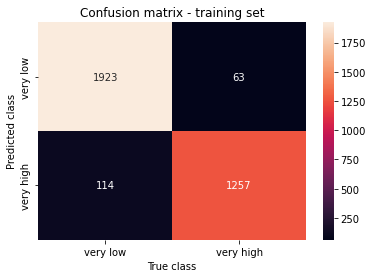

Accuracy: 0.95
Micro precision: 0.95
Micro recall: 0.95
Micro F1-score: 0.95
Macro precision: 0.95
Macro recall: 0.94
Macro F1-score: 0.95
Weighted precision: 0.95
Weighted recall: 0.95
Weighted F1-score: 0.95
              precision    recall  f1-score   support

    very low       0.94      0.97      0.96      1986
   very high       0.95      0.92      0.93      1371

    accuracy                           0.95      3357
   macro avg       0.95      0.94      0.95      3357
weighted avg       0.95      0.95      0.95      3357



In [197]:
cmtx = confusion_matrix(y_train, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=y_val.cat.categories, yticklabels=y_pred.cat.categories)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - training set")
plt.savefig(os.path.join(p_dir, "confusion_matrix_train.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_train, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_train, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_train, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_train, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_train, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_train, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_train, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_train, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_train, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_train, y_pred, average="weighted")))

print(classification_report(y_train, y_pred, target_names=cat_lbl))

## Test dataset (out-of_sample)

In [198]:
img_dir = "../images_medium"

x_test = pd.read_pickle(os.path.join(p_dir, "x_test.pkl"))
y_test = pd.read_pickle(os.path.join(p_dir, "y_test.pkl"))
test_gen = test_generator(x_test, y_test, img_dir, cat_lbl)
y_pred_prob = model.predict(test_gen, steps=y_test.shape[0])
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred = pd.Series([cat_lbl[i] for i in y_pred]).astype("category").cat.reorder_categories(cat_lbl)

In [199]:
print("F1 score: {:0.2f}".format(f1_score(y_test, y_pred, pos_label="very high")))

F1 score: 0.94


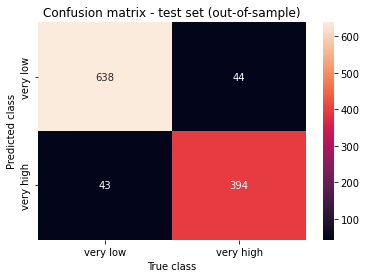

Accuracy: 0.92
Micro precision: 0.92
Micro recall: 0.92
Micro F1-score: 0.92
Macro precision: 0.92
Macro recall: 0.92
Macro F1-score: 0.92
Weighted precision: 0.92
Weighted recall: 0.92
Weighted F1-score: 0.92
              precision    recall  f1-score   support

    very low       0.94      0.94      0.94       682
   very high       0.90      0.90      0.90       437

    accuracy                           0.92      1119
   macro avg       0.92      0.92      0.92      1119
weighted avg       0.92      0.92      0.92      1119



In [200]:
cmtx = confusion_matrix(y_test, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=y_test.cat.categories, yticklabels=y_pred.cat.categories)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - test set (out-of-sample)")
plt.savefig(os.path.join(p_dir, "confusion_matrix.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_test, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_test, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_test, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="weighted")))

print(classification_report(y_test, y_pred, target_names=cat_lbl))

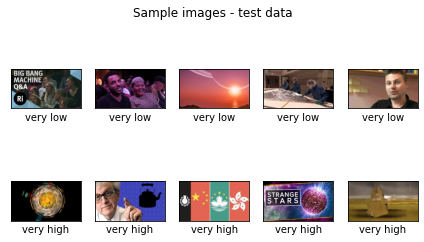

In [201]:
s = combo.loc[combo["id_video"].isin(x_val["id_video"]), ["id_video", "qtl"]].groupby("qtl", as_index=False).apply(lambda x: x.sample(5, random_state=118))

n_images = 5
fig, axs = plt.subplots(len(cat_lbl), n_images)
i = 0

for idx, row in s.iterrows():
    img = Image.open(os.path.join(img_dir, "{}.jpg".format(row["id_video"])))
    axs[i // n_images, i % n_images].imshow(img)
    axs[i // n_images, i % n_images].xaxis.set_ticklabels([])
    axs[i // n_images, i % n_images].xaxis.set_ticks([])
    axs[i // n_images, i % n_images].set_xlabel(row["qtl"])
    axs[i // n_images, i % n_images].yaxis.set_ticklabels([])
    axs[i // n_images, i % n_images].yaxis.set_ticks([])
    i += 1
plt.tight_layout()
plt.suptitle("Sample images - test data")
plt.show()
fig.savefig(os.path.join(p_dir, "sample_images_val.jpg"))

# ROC Curve

In [202]:
class mybinarizer:
    
    def transform(self, s: pd.Series, cats: list) -> np.ndarray:
        d = list()
        for i, v in enumerate(s):
            d.append([l == v for l in cats])
        return np.array(d, dtype="int32")
    
    def reverse_transform(self, arr: np.ndarray) -> pd.Series:
        d = list()
        for i, v in enumerate(arr):
            ct = 0
            for j in v:
                if j == 1:
                    d.append(cat_lbl[ct])
                    continue
                ct += 1
        return pd.Series(d, name="qtl")

## Training dataset (in sample)

In [203]:
lb = mybinarizer()
y_train_no = lb.transform(y_train, cat_lbl)[:, 1]
y_pred_no = y_train_prob[:, 1]
fpr, tpr, thr = roc_curve(y_train_no, y_pred_no)

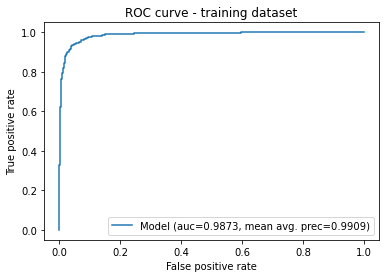

In [204]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_train_no, y_pred_no)

# plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - training dataset")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve_train.jpg"))
plt.show()

## Test dataset (out-of-sample)

In [205]:
lb = mybinarizer()
y_test_no = lb.transform(y_test, cat_lbl)[:, 1]
y_pred_no = y_pred_prob[:,  1]
fpr, tpr, thr = roc_curve(y_test_no, y_pred_no)

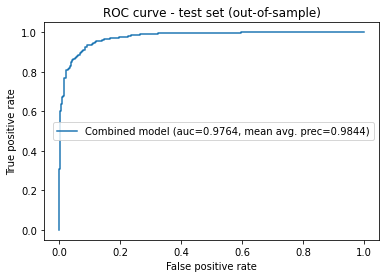

In [206]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_test_no, y_pred_no)

# plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Combined model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
df_roc = pd.DataFrame({"fpr": fpr, "tpr": tpr})
df_roc.to_pickle("../roc_combo.pkl")
d_roc = pd.DataFrame({"auc": [auc_model], "mavgp": [mavgp]})
d_roc.to_pickle("../d_combo.pkl")

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - test set (out-of-sample)")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve.jpg"))
plt.show()

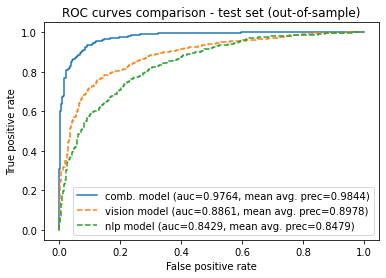

In [207]:
df_combo = pd.read_pickle("../roc_combo.pkl")
d_combo = pd.read_pickle("../d_combo.pkl")
plt.plot(df_combo["fpr"], df_combo["tpr"], label="comb. model (auc={:0.4f}, mean avg. prec={:0.4f})".format(d_combo["auc"][0], d_combo["mavgp"][0]))
df_img = pd.read_pickle("../roc_img.pkl")
d_img = pd.read_pickle("../d_img.pkl")
plt.plot(df_img["fpr"], df_img["tpr"], label="vision model (auc={:0.4f}, mean avg. prec={:0.4f})".format(d_img["auc"][0], d_img["mavgp"][0]), linestyle="dashed")
df_nlp = pd.read_pickle("../roc_nlp.pkl")
d_nlp = pd.read_pickle("../d_nlp.pkl")
plt.plot(df_nlp["fpr"], df_nlp["tpr"], label="nlp model (auc={:0.4f}, mean avg. prec={:0.4f})".format(d_nlp["auc"][0], d_nlp["mavgp"][0]), linestyle="dashed")

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curves comparison - test set (out-of-sample)")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve_all.jpg"))
plt.show()

# Class probability histograms

## Without middle classes

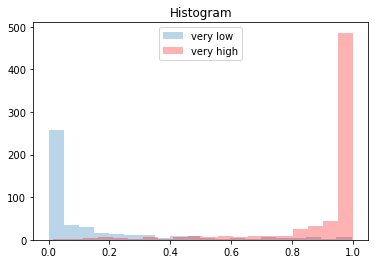

In [208]:
m0 = y_test_no == 0
c0 = y_pred_prob[m0, 1]
m1 = y_test_no == 1
c1 = y_pred_prob[m1, 1]

plt.hist(c0, alpha=0.3, bins=20)
plt.hist(c1, color="red", alpha=0.3, bins=20)
plt.title("Histogram")
plt.legend(cat_lbl, loc="upper center")
plt.savefig(os.path.join(p_dir, "histogram.jpg"))
plt.show()

## Including middle classes

In [209]:
# cat_lbl2 = ["very low", "low", "high", "very high"]
# combo2 = combo.copy()
# combo2.loc[:, "qtl"] = pd.qcut(combo.ln_vc_norm, len(cat_lbl2), labels=cat_lbl2, precision=6)

In [76]:
# combo2 = combo2.loc[combo2.qtl.isin(["low", "high"]), :]
# combo2.qtl = combo2.qtl.cat.remove_unused_categories()

y2 = combo2.qtl
x2 = combo2.loc[:, [c for c in combo2.columns if c != "qtl"]]

x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, random_state=42)
x_train2, x_val2, y_train2, y_val2 = train_test_split(x_train2, y_train2, test_size=0.25, random_state=4711)

print(x_train2.shape[0], x_val2.shape[0], x_test2.shape[0])

2839 947 947


In [77]:
test_gen2 = test_generator(x_test2, y_test2, img_dir, cat_lbl)
y_pred_prob2 = model.predict(test_gen2, steps=y_test2.shape[0])
y_pred2 = np.argmax(y_pred_prob2, axis=1)
y_pred2 = pd.Series([cat_lbl[i] for i in y_pred2]).astype("category").cat.reorder_categories(cat_lbl)

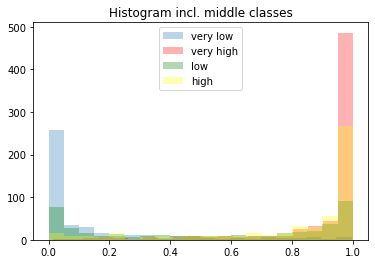

In [212]:
m0 = y_test_no == 0
c0 = y_pred_prob[m0, 1]
m1 = y_test_no == 1
c1 = y_pred_prob[m1, 1]

m3 = y_test2 == "low"
c2 = y_pred_prob2[m3, 1]

m4 = y_test2 == "high"
c3 = y_pred_prob2[m4, 1]

plt.hist(c0, alpha=0.3, label="", bins=20)
plt.hist(c1, color="red", alpha=0.3, label="", bins=20)
plt.hist(c2, color="green", alpha=0.3, label="", bins=20)
plt.hist(c3, color="yellow", alpha=0.3, label="", bins=20)
plt.title("Histogram incl. middle classes")
plt.legend(cat_lbl + ["low", "high"], loc="upper center")
plt.savefig(os.path.join(p_dir, "histogram_w_medium.jpg"))
plt.show()

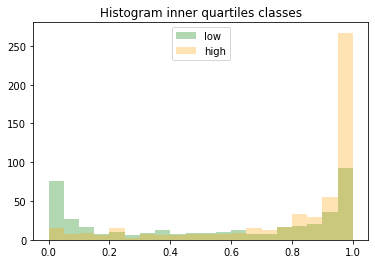

In [213]:
m3 = y_test2 == "low"
c2 = y_pred_prob2[m3, 1]

m4 = y_test2 == "high"
c3 = y_pred_prob2[m4, 1]

plt.hist(c2, color="green", alpha=0.3, label="", bins=20)
plt.hist(c3, color="orange", alpha=0.3, label="", bins=20)
plt.title("Histogram inner quartiles classes")
plt.legend(["low", "high"], loc="upper center")
plt.savefig(os.path.join(p_dir, "histogram_medium.jpg"))
plt.show()

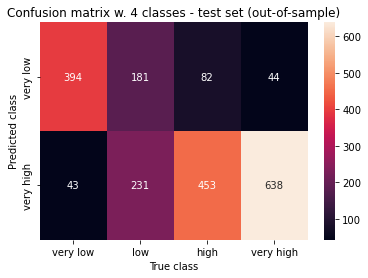

In [214]:
vhvl = pd.concat([y_pred.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1, ignore_index=True)
vhvl.columns = ["pred", "truth"]

hl = pd.concat([y_pred2.reset_index(drop=True), y_test2.reset_index(drop=True)], axis=1, ignore_index=True)
hl.columns = ["pred", "truth"]

tot = pd.concat([vhvl, hl], axis=0)
tot = tot.groupby(["pred", "truth"]).agg({"pred": "count"})
tot.rename(columns={"pred": "count"}, inplace=True)
tot.reset_index(inplace=True)
tot = tot.pivot(index="pred", columns="truth", values="count")
tot = tot.reindex(["very low", "low", "high", "very high"], axis=1)

sb.heatmap(tot, annot=True, fmt="d")
plt.ylabel("Predicted class")
plt.xlabel("True class")
plt.title("Confusion matrix w. 4 classes - test set (out-of-sample)")
plt.savefig(os.path.join(p_dir, "confusion_matrix_4 classes.jpg"))
plt.show()

# Sample images with titles

In [215]:
combo.loc[combo["channel_name"] == "CGP Grey", :].sort_values("ln_vc_norm", ascending=False).head(15)

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,id_channel,view_count_channel,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl
3249,iHzzSao6ypE,The Simple Solution to Traffic,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2016-08-31 12:36:39+00:00,682773.0,20459.0,26495364.0,64,30,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,1.659564,very high
3338,rNu8XDBSn10,"The Difference between the United Kingdom, Gre...",UC2C_jShtL725hvbm1arSV9w,CGP Grey,2011-01-30 16:19:41+00:00,275190.0,10881.0,19081762.0,131,78,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,1.331327,very high
3291,kF8I_r9XT7A,How to Become Pope,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2013-02-19 13:30:39+00:00,260288.0,4803.0,15337439.0,106,18,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,1.112891,very high
3220,oAHbLRjF0vo,The Better Boarding Method Airlines Won't Use,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2019-02-04 18:31:38+00:00,418999.0,8819.0,14510184.0,34,45,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,1.057445,very high
3248,rStL7niR7gs,The Rules for Rulers,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2016-10-24 15:15:59+00:00,419256.0,7164.0,14508362.0,62,20,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,1.057319,very high
3273,7Pq-S557XQU,Humans Need Not Apply,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2014-08-13 12:00:03+00:00,316083.0,6458.0,14370579.0,88,21,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,1.047777,very high
3259,jNgP6d9HraI,Brief History of the Royal Family,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2015-09-09 07:10:21+00:00,219467.0,4661.0,13522905.0,75,33,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,0.986979,very high
3287,qMkYlIA7mgw,Canada & The United States (Bizarre Borders Pa...,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2013-06-05 21:35:43+00:00,149246.0,2041.0,13320196.0,102,51,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,0.971875,very high
3280,uqH_Y1TupoQ,The Law You Won't Be Told,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2014-02-12 15:12:25+00:00,206997.0,3735.0,12441879.0,94,25,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,0.903662,very high
3275,ASSOQDQvVLU,American Empire,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2014-07-03 14:35:38+00:00,150020.0,3437.0,11118117.0,89,15,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,0.791170,very high


In [216]:
titles = [
    "These are the asteroids to worry about",
    "The Egg - A Short Story",
    "What is the Wave/Particle Duality? Part 1",
    "How High Can We Build?",
    "Why It Sucks to Be a Male Hyena",
    "The Simple Solution to Traffic"
]
s = combo.loc[combo["title"].isin(titles), ["id_video", "title", "channel_name"]].sort_values(["channel_name"])

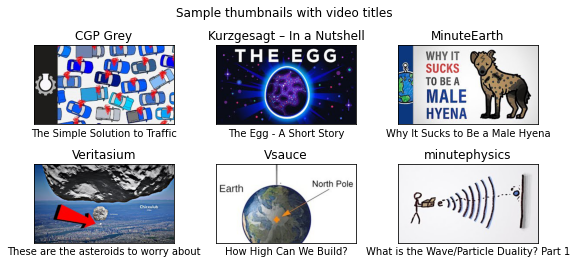

In [217]:
ipr = 3
fig, axs = plt.subplots(len(titles) // ipr, ipr, figsize=(8, 4))
i = 0
for idx, row in s.iterrows():
    img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"]))
    img = load_img(img_path)
    axs[i // ipr, i % ipr].imshow(img)
    axs[i // ipr, i % ipr].xaxis.set_ticklabels([])
    axs[i // ipr, i % ipr].xaxis.set_ticks([])
    axs[i // ipr, i % ipr].set_xlabel(row["title"])
    axs[i // ipr, i % ipr].set_title(row["channel_name"])
    axs[i // ipr, i % ipr].yaxis.set_ticklabels([])
    axs[i // ipr, i % ipr].yaxis.set_ticks([])
    i += 1
plt.suptitle("Sample thumbnails with video titles", x=0.56)
# plt.tight_layout()     
plt.subplots_adjust(left=None, bottom=None, right=1.0, top=None, wspace=0.3, hspace=None)
plt.savefig(os.path.join(p_dir, "Sample images with titles.jpg"))
plt.show()

In [218]:
combo.loc[combo["channel_name"] == "OverSimplified", :].sort_values("ln_vc_norm", ascending=False).head(10)

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,id_channel,view_count_channel,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl
3158,_uk_6vfqwTA,WW2 - OverSimplified (Part 1),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2018-03-15 18:52:13+00:00,674812.0,29126.0,59598408.0,45,29,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,2.421811,very high
3152,I79TpDe3t2g,The Cold War - OverSimplified (Part 1),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2019-01-24 22:43:10+00:00,540455.0,14842.0,38745436.0,35,38,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.991195,very high
3157,fo2Rb9h788s,WW2 - OverSimplified (Part 2),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2018-03-15 18:52:41+00:00,512250.0,12171.0,37955519.0,45,29,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.970597,very high
3155,gzALIXcY4pg,The American Revolution - OverSimplified (Par...,UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2018-08-30 18:00:33+00:00,416204.0,12385.0,35028220.0,40,50,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.890336,very high
3164,dHSQAEam2yc,WW1 - Oversimplified (Part 1),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2016-10-21 11:44:18+00:00,384816.0,7014.0,32078562.0,62,29,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.802370,very high
3146,tsxmyL7TUJg,The American Civil War - OverSimplified (Part 1),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2020-01-31 23:00:10+00:00,468609.0,13407.0,30519439.0,23,48,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.752546,very high
3162,ATlila3e9dM,Hitler - OverSimplified (Part 1),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2017-04-18 15:52:33+00:00,379815.0,9398.0,26662380.0,56,32,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.617435,very high
3151,OIYy32RuHao,The Cold War - OverSimplified (Part 2),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2019-01-24 22:45:32+00:00,422374.0,8076.0,25677442.0,35,38,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.579795,very high
3149,8qRZcXIODNU,The French Revolution - OverSimplified (Part 1),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2019-06-28 23:41:05+00:00,395085.0,8633.0,24287928.0,30,47,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.524161,very high
3163,Mun1dKkc_As,WW1 - Oversimplified (Part 2),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2016-10-21 11:44:32+00:00,305395.0,7555.0,24159099.0,62,29,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.518843,very high


In [219]:
titles1 = [
    "Simulating Natural Selection",
    "Mutations and the First Replicators",
    "Exponential growth and epidemics",
    "But how does bitcoin actually work?",
    "WW2 - OverSimplified (Part 1)",
    "WW1 - Oversimplified (Part 1)"
]
s1 = combo.loc[combo["title"].isin(titles1), ["id_video", "title", "channel_name"]].sort_values(["channel_name", "title"])

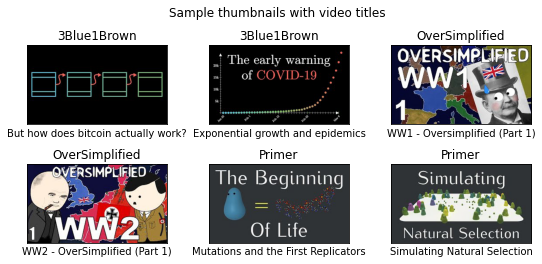

In [220]:
ipr = 3
fig, axs = plt.subplots(len(titles1) // ipr, ipr, figsize=(8, 4))
i = 0
for idx, row in s1.iterrows():
    img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"]))
    img = load_img(img_path)
    axs[i // ipr, i % ipr].imshow(img)
    axs[i // ipr, i % ipr].xaxis.set_ticklabels([])
    axs[i // ipr, i % ipr].xaxis.set_ticks([])
    axs[i // ipr, i % ipr].set_xlabel(row["title"])
    axs[i // ipr, i % ipr].set_title(row["channel_name"])
    axs[i // ipr, i % ipr].yaxis.set_ticklabels([])
    axs[i // ipr, i % ipr].yaxis.set_ticks([])
    # if i % 2 == 0:
    #     axs[i // 2, i % 2].set_ylabel(row["channel_name"])
    i += 1
plt.suptitle("Sample thumbnails with video titles", x=0.56)
# plt.tight_layout(pad=3)
plt.subplots_adjust(left=None, bottom=None, right=1.0, top=None, wspace=0.3, hspace=None)
plt.savefig(os.path.join(p_dir, "Channel sample images with titles.jpg"))
plt.show()

In [221]:
res = pd.concat([x_test.reset_index(), y_test.reset_index(), y_pred.reset_index()], axis=1)
res.drop(columns=["index"], inplace=True)
res.rename(columns={0: "pred"}, inplace=True)
res["qtl"] = res["qtl"].astype(object)
res.head()

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,id_channel,view_count_channel,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl,pred
0,70sAqfZC3Wo,I SMELL YOU -- Mind Blow #74,UCqmugCqELzhIMNYnsjScXXw,Vsauce2,2013-11-23 18:15:53+00:00,30356.0,612.0,2677825.0,97,28,UCqmugCqELzhIMNYnsjScXXw,671152937,2010-12-07 16:43:13+00:00,132,4370000.0,393,-0.489758,very high,very high
1,EXkf62qGFII,Soft autonomous earthworm robot at MIT,UCFe-pfe0a9bDvWy74Jd7vFg,Massachusetts Institute of Technology (MIT),2012-08-09 22:41:38+00:00,3080.0,53.0,828989.0,112,38,UCFe-pfe0a9bDvWy74Jd7vFg,88512314,2009-01-14 16:58:54+00:00,155,724000.0,592,0.135415,very high,very low
2,-FYvy3_egHw,The New Astronomy: Crash Course History of Sci...,UCX6b17PVsYBQ0ip5gyeme-Q,CrashCourse,2018-07-09 22:19:52+00:00,5241.0,111.0,291095.0,41,54,UCX6b17PVsYBQ0ip5gyeme-Q,1546387741,2006-05-20 02:43:42+00:00,187,12700000.0,1334,-3.775708,very low,very low
3,Wqe_5FBF8jk,Planetary Deep Drill Field Test - SciTech,UCi0TZmFfgS4oQPcRQ6-KRXg,The Planetary Society,2015-12-17 18:35:10+00:00,59.0,0.0,1351.0,72,41,UCi0TZmFfgS4oQPcRQ6-KRXg,8212558,2007-10-19 19:41:36+00:00,170,69700.0,337,-3.943355,very low,very low
4,KRzQVD6LfCE,Road Trip Part 2: The Long Dark,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2019-05-08 10:00:04+00:00,1148.0,72.0,73711.0,31,31,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,-4.225009,very low,very low


In [222]:
# res.loc[(res["pred"] == res["qtl"]) & ("title" == "This is why we can't have nice things"), :].sort_values("ln_vc_norm", ascending=False).iloc[:10,:]
res.loc[(res["pred"] == res["qtl"]), :].sort_values("ln_vc_norm", ascending=False).iloc[60:70,:]

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,id_channel,view_count_channel,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl,pred
135,2lv6Vs12jLc,How NASA Reinvented The Wheel - Shape Memory A...,UCR1IuLEqb6UEA_zQ81kwXfg,Real Engineering,2018-09-22 11:48:36+00:00,99051.0,2304.0,4861440.0,39,51,UCR1IuLEqb6UEA_zQ81kwXfg,276663744,2013-09-12 06:45:57+00:00,99,3130000.0,128,0.440302,very high,very high
447,tB5-JahAXfc,How Good Is Your Eyesight? (TEST),UCC552Sd-3nyi_tk2BudLUzA,AsapSCIENCE,2015-04-02 14:14:10+00:00,120796.0,3248.0,15037297.0,80,33,UCC552Sd-3nyi_tk2BudLUzA,1538029538,2012-05-28 17:33:43+00:00,115,9740000.0,374,0.434292,very high,very high
523,ex5y6OVVHe0,How Your Dog Can Protect You Before You're Born,UCeiYXex_fwgYDonaTcSIk6w,MinuteEarth,2014-01-07 21:14:51+00:00,53427.0,970.0,3944747.0,95,47,UCeiYXex_fwgYDonaTcSIk6w,363864862,2011-10-20 02:21:51+00:00,122,2600000.0,266,0.416873,very high,very high
691,ofTb57aZHZs,The Birthday Paradox,UCqmugCqELzhIMNYnsjScXXw,Vsauce2,2018-12-18 22:02:06+00:00,217929.0,4357.0,6574723.0,36,20,UCqmugCqELzhIMNYnsjScXXw,671152937,2010-12-07 16:43:13+00:00,132,4370000.0,393,0.408469,very high,very high
253,WsksFbFZeeU,7 Science Tricks with Surface Tension,UC7DdEm33SyaTDtWYGO2CwdA,Physics Girl,2015-04-21 12:09:34+00:00,15789.0,424.0,3077031.0,80,37,UC7DdEm33SyaTDtWYGO2CwdA,148707406,2011-10-21 15:36:08+00:00,122,2050000.0,183,0.406125,very high,very high
669,RyRKKkls3I8,Can You Draw A Perfect Circle?,UClq42foiSgl7sSpLupnugGA,D!NG,2018-01-12 20:00:18+00:00,83336.0,2504.0,2727241.0,47,30,UClq42foiSgl7sSpLupnugGA,176352780,2015-09-02 15:46:33+00:00,75,1830000.0,255,0.398975,very high,very high
526,ZKmyqN1hLhk,"I Made An Actual Infinite Staircase, but it's ...",UCQALLeQPoZdZC4JNUboVEUg,Jabrils,2020-10-01 13:00:09+00:00,28470.0,737.0,691414.0,14,66,UCQALLeQPoZdZC4JNUboVEUg,16208792,2015-07-06 04:47:34+00:00,77,467000.0,76,0.392410,very high,very high
178,jAhjPd4uNFY,Genetic Engineering Will Change Everything For...,UCsXVk37bltHxD1rDPwtNM8Q,Kurzgesagt – In a Nutshell,2016-08-10 12:01:38+00:00,557683.0,11649.0,23705190.0,64,59,UCsXVk37bltHxD1rDPwtNM8Q,1566316247,2013-07-09 20:17:20+00:00,101,16100000.0,145,0.386875,very high,very high
288,IJhgZBn-LHg,How Earth Moves,UC6nSFpj9HTCZ5t-N3Rm3-HA,Vsauce,2016-06-13 14:48:34+00:00,571048.0,17134.0,24946891.0,66,15,UC6nSFpj9HTCZ5t-N3Rm3-HA,2141610094,2007-07-30 20:43:33+00:00,173,17100000.0,382,0.377671,very high,very high
674,p1PgNbgWSyY,GOING SUPERSONIC with U.S. Air Force Thunderbi...,UC6107grRI4m0o2-emgoDnAA,SmarterEveryDay,2020-05-18 21:55:08+00:00,332536.0,5619.0,14475558.0,19,98,UC6107grRI4m0o2-emgoDnAA,974567798,2006-04-04 04:12:24+00:00,188,9980000.0,344,0.371878,very high,very high


In [223]:
titles2 = [
    "A LIVING ROCK? -- Mind Blow #69",
    "Does this look white to you?",
    "Football War - MiniWars #2",
    "What Will We Miss?",
    "The True Science of Parallel Universes",
    "Childbirth vs Getting Kicked in the Balls"
]
s2 = res.loc[res["title"].isin(titles2), ["id_video", "title", "channel_name", "ln_vc_norm"]].sort_values(["channel_name", "title"])

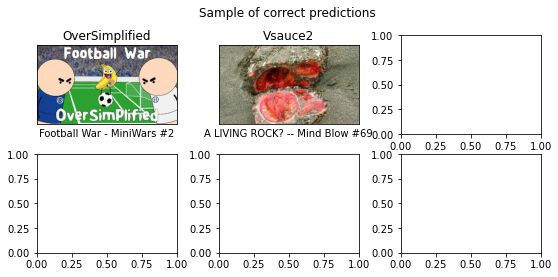

In [224]:
ipr = 3
fig, axs = plt.subplots(len(titles2) // ipr, ipr, figsize=(8, 4))
i = 0
for idx, row in s2.iterrows():
    img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"]))
    img = load_img(img_path)
    axs[i // ipr, i % ipr].imshow(img)
    axs[i // ipr, i % ipr].xaxis.set_ticklabels([])
    axs[i // ipr, i % ipr].xaxis.set_ticks([])
    axs[i // ipr, i % ipr].set_xlabel(row["title"])
    axs[i // ipr, i % ipr].set_title(row["channel_name"])
    axs[i // ipr, i % ipr].yaxis.set_ticklabels([])
    axs[i // ipr, i % ipr].yaxis.set_ticks([])
    # if i % 2 == 0:
    #     axs[i // 2, i % 2].set_ylabel(row["channel_name"])
    i += 1
plt.suptitle("Sample of correct predictions", x=0.56)
# plt.tight_layout(pad=3)
plt.subplots_adjust(left=None, bottom=None, right=1.0, top=None, wspace=0.3, hspace=None)
plt.savefig(os.path.join(p_dir, "Sample of correct predictions.jpg"))
plt.show()

In [225]:
# res.loc[(res["pred"] == res["qtl"]) & ("title" == "This is why we can't have nice things"), :].sort_values("ln_vc_norm", ascending=False).iloc[:10,:]
res.loc[(res["pred"] != res["qtl"]), :].sort_values("ln_vc_norm", ascending=True).iloc[80:90,:]

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,id_channel,view_count_channel,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl,pred
274,aOCSDLHoQCc,MIT Students Write Pi,UCFe-pfe0a9bDvWy74Jd7vFg,Massachusetts Institute of Technology (MIT),2016-03-14 13:23:03+00:00,16526.0,458.0,1171249.0,69,21,UCFe-pfe0a9bDvWy74Jd7vFg,88512314,2009-01-14 16:58:54+00:00,155,724000.0,592,0.481035,very high,very low
423,lX5LPwigyi0,Elon Musk's Final Warning About AI: Should We ...,UCxoz4YfS4M3H3C57FD4jW4Q,Science Time,2020-09-19 19:00:04+00:00,9924.0,372.0,393382.0,15,81,UCxoz4YfS4M3H3C57FD4jW4Q,15574624,2019-08-17 18:03:38+00:00,28,232000.0,108,0.528044,very high,very low
309,ti_E2ZKZpC4,Chemical Curiosities: Surprising Science and D...,UCYeF244yNGuFefuFKqxIAXw,The Royal Institution,2012-02-16 13:18:27+00:00,27948.0,935.0,3200258.0,118,88,UCYeF244yNGuFefuFKqxIAXw,128175239,2009-09-16 11:05:59+00:00,147,1070000.0,934,1.095573,very high,very low
409,1ZmYX5nVwLc,Yutu-2 rolls across the Moon,UCi0TZmFfgS4oQPcRQ6-KRXg,The Planetary Society,2019-01-14 17:37:06+00:00,1657.0,52.0,255561.0,35,28,UCi0TZmFfgS4oQPcRQ6-KRXg,8212558,2007-10-19 19:41:36+00:00,170,69700.0,337,1.299261,very high,very low
157,4IsTheUJbgk,Hayabusa2 SCI tests,UCi0TZmFfgS4oQPcRQ6-KRXg,The Planetary Society,2019-04-05 20:48:55+00:00,174.0,10.0,280144.0,32,19,UCi0TZmFfgS4oQPcRQ6-KRXg,8212558,2007-10-19 19:41:36+00:00,170,69700.0,337,1.391103,very high,very low
345,0HaikdgRuAs,Bill Nye on the Chang'e-4 Moon Landing,UCi0TZmFfgS4oQPcRQ6-KRXg,The Planetary Society,2019-01-15 23:02:19+00:00,8226.0,1386.0,447633.0,35,38,UCi0TZmFfgS4oQPcRQ6-KRXg,8212558,2007-10-19 19:41:36+00:00,170,69700.0,337,1.859773,very high,very low
258,_luhn7TLfWU,MIT cheetah robot lands the running jump,UCFe-pfe0a9bDvWy74Jd7vFg,Massachusetts Institute of Technology (MIT),2015-05-28 20:40:30+00:00,163037.0,6818.0,21006290.0,79,40,UCFe-pfe0a9bDvWy74Jd7vFg,88512314,2009-01-14 16:58:54+00:00,155,724000.0,592,3.367786,very high,very low


In [226]:
titles3 = [
    "Derek Muller - The Element of Truth",
    "Cracking the Puzzle of Biodiversity",
    "StarTalk Snippet: Google Says What?",
    "Ask Joe Stuff #3",
    "Announcing the Crash Course Coins",
    "David Moore: Tabletop Physics"
]
s3 = res.loc[res["title"].isin(titles3), ["id_video", "title", "channel_name", "ln_vc_norm"]].sort_values(["channel_name"])

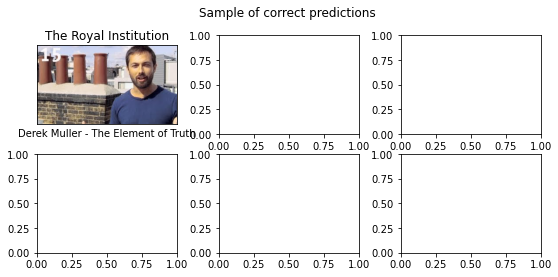

In [227]:
ipr = 3
fig, axs = plt.subplots(len(titles3) // ipr, ipr, figsize=(8, 4))
i = 0
for idx, row in s3.iterrows():
    img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"]))
    img = load_img(img_path)
    axs[i // ipr, i % ipr].imshow(img)
    axs[i // ipr, i % ipr].xaxis.set_ticklabels([])
    axs[i // ipr, i % ipr].xaxis.set_ticks([])
    axs[i // ipr, i % ipr].set_xlabel(row["title"])
    axs[i // ipr, i % ipr].set_title(row["channel_name"])
    axs[i // ipr, i % ipr].yaxis.set_ticklabels([])
    axs[i // ipr, i % ipr].yaxis.set_ticks([])
    # if i % 2 == 0:
    #     axs[i // 2, i % 2].set_ylabel(row["channel_name"])
    i += 1
plt.suptitle("Sample of correct predictions", x=0.56)
# plt.tight_layout(pad=3)
plt.subplots_adjust(left=None, bottom=None, right=1.0, top=None, wspace=0.3, hspace=None)
plt.savefig(os.path.join(p_dir, "Sample of incorrect predictions.jpg"))
plt.show()

In [228]:
titles4 = [
    "Does this look white to you?",
    "Announcing the Crash Course Coins"
]
s4 = res.loc[res["title"].isin(titles4), ["id_video", "title", "channel_name", "ln_vc_norm"]].sort_values(["channel_name", "title"])

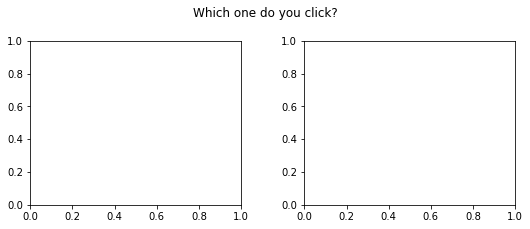

In [229]:
ipr = 2
fig, axs = plt.subplots(len(titles4) // ipr, ipr, figsize=(8, 4))
i = 0

# img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"][0]))
# img = load_img(img_path)
# axs[0, 0].imshow()

for idx, row in s4.iterrows():
    img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"]))
    img = load_img(img_path)
    axs[i % ipr].imshow(img)
    axs[i % ipr].xaxis.set_ticklabels([])
    axs[i % ipr].xaxis.set_ticks([])
    axs[i % ipr].set_xlabel(row["title"])
    axs[i % ipr].set_title(row["channel_name"])
    axs[i % ipr].yaxis.set_ticklabels([])
    axs[i % ipr].yaxis.set_ticks([])
    # if i % 2 == 0:
    #     axs[i // 2, i % 2].set_ylabel(row["channel_name"])
    i += 1
plt.suptitle("Which one do you click?", x=0.5, y=0.85)
plt.tight_layout(pad=3)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
plt.savefig(os.path.join(p_dir, "Which one do you click.jpg"))
plt.show()

# Stuff for Helmut

In [3]:
combo = pd.read_pickle(os.path.join(p_dir, "combo.pkl"))

In [6]:
combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10328 entries, 0 to 16299
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   id_video            10328 non-null  object             
 1   title               10328 non-null  object             
 2   channel_id          10328 non-null  object             
 3   channel_name        10328 non-null  object             
 4   published_video     10328 non-null  datetime64[ns, UTC]
 5   like_count          10328 non-null  float64            
 6   dislike_count       10328 non-null  float64            
 7   view_count_video    10328 non-null  float64            
 8   published_mth       10328 non-null  int64              
 9   title_len           10328 non-null  int64              
 10  id_channel          10328 non-null  object             
 11  view_count_channel  10328 non-null  int64              
 12  published_channel   10328 non-nu

In [4]:
channel = combo.groupby(["channel_name", "qtl"]).agg({"id_video": "count"}).copy().reset_index()

In [5]:
comb = combo.copy()
comb.loc[comb["channel_name"].str.len() > 15, "channel_name"] = comb["channel_name"].str.slice(0, 15) + "..."

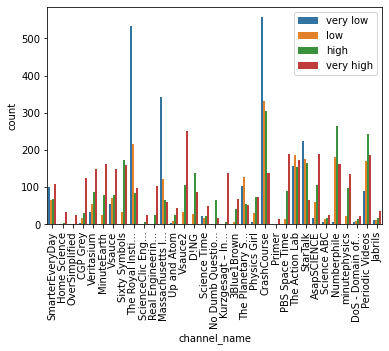

In [6]:
sb.countplot(x="channel_name", hue="qtl", data=comb)
plt.xticks(rotation=90)
plt.legend().set_title(None)
plt.savefig(os.path.join(p_dir, "Channel_groundTruth_distribution.jpg"), bbox_inches = "tight")
plt.show()

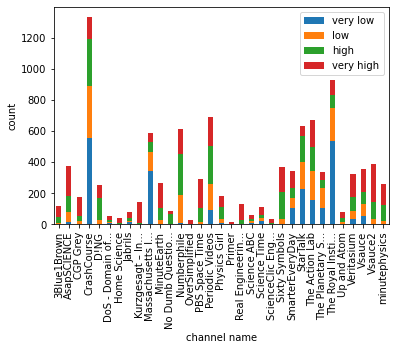

In [16]:
g = comb.groupby(["channel_name", "qtl"]).agg({"id_video": "count"})
g.rename(columns={"id_video": "cnt"}, inplace=True)
g = g.reset_index().pivot(index="channel_name", columns="qtl", values="cnt")
g.plot(kind="bar", stacked=True)
plt.ylabel("count")
plt.xlabel("channel name")
plt.legend().set_title(None)
plt.savefig(os.path.join(p_dir, "Channel_groundTruth_distribution2.jpg"), bbox_inches = "tight")
plt.show()

In [29]:
tot = pd.concat([combo], axis=0)
tot.shape

(5595, 18)

In [30]:
img_dir = "../images_medium"

tot_gen = test_generator(tot.loc[:, [c for c in tot.columns if c != "qtl"]], tot["qtl"], img_dir, cat_lbl)
y_tot_prob = model.predict(tot_gen, steps=tot["qtl"].shape[0])
y_pred = np.argmax(y_tot_prob, axis=1)
y_pred = pd.Series([cat_lbl[i] for i in y_pred]).astype("category").cat.reorder_categories(cat_lbl)
tot = pd.concat([tot.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)                        

2021-12-29 12:08:14.885286: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-29 12:08:20.560515: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [31]:
# tot = pd.concat([train, val, test], axis=0)
tot.rename(columns={0: "pred"}, inplace=True)
tot.to_pickle(os.path.join(p_dir, "tot.pkl"))
tot.shape

(5595, 19)

In [5]:
tot = pd.read_pickle(os.path.join(p_dir, "tot.pkl"))

In [6]:
tot["gt"] = (tot["qtl"] == "very high").astype(int)
tot["pred"] = (tot["pred"] == "very high").astype(int)
g = tot.groupby(["channel_name"]).agg({"id_video": "count", "pred": "sum", "gt": "sum"}).reset_index()
g.rename(columns={"id_video": "video_cnt", "pred": "pred_cnt", "gt": "gt_cnt"}, inplace=True)
g["gt_ratio"] = g["gt_cnt"] / g["video_cnt"]
g["pred_ratio"] = g["pred_cnt"] / g["video_cnt"]

In [7]:
tot.head()

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,id_channel,view_count_channel,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl,pred,gt
0,toVfvRhWbj8,How Does A Carburetor Work? | Transparent Carb...,UC6107grRI4m0o2-emgoDnAA,SmarterEveryDay,2021-06-30 16:01:11+00:00,308158.0,2265.0,6157911.0,6,98,UC6107grRI4m0o2-emgoDnAA,974567798,2006-04-04 04:12:24+00:00,188,9980000.0,344,-0.482845,very high,1,1
1,TCxoZlFqzwA,How Does Film ACTUALLY Work? (It's MAGIC) [Ph...,UC6107grRI4m0o2-emgoDnAA,SmarterEveryDay,2021-06-13 21:14:30+00:00,108396.0,1653.0,2494470.0,6,91,UC6107grRI4m0o2-emgoDnAA,974567798,2006-04-04 04:12:24+00:00,188,9980000.0,344,-1.386507,very high,1,1
2,MUaTOoVmg1Q,"Exploding Weed Seeds (28,546 fps Slow Motion)-...",UC6107grRI4m0o2-emgoDnAA,SmarterEveryDay,2021-05-30 14:00:14+00:00,132375.0,2270.0,2478806.0,7,68,UC6107grRI4m0o2-emgoDnAA,974567798,2006-04-04 04:12:24+00:00,188,9980000.0,344,-1.392806,very high,1,1
3,flmkQZvN_g8,What happens when 2 Weedeaters Hit Each Other?...,UC6107grRI4m0o2-emgoDnAA,SmarterEveryDay,2021-04-30 01:02:05+00:00,126450.0,2480.0,2911797.0,8,96,UC6107grRI4m0o2-emgoDnAA,974567798,2006-04-04 04:12:24+00:00,188,9980000.0,344,-1.231813,very high,1,1
4,g3Ud6mHdhlQ,How Do Nuclear Submarines Make Oxygen?- Smarte...,UC6107grRI4m0o2-emgoDnAA,SmarterEveryDay,2021-02-21 14:00:10+00:00,178969.0,2349.0,5016298.0,10,61,UC6107grRI4m0o2-emgoDnAA,974567798,2006-04-04 04:12:24+00:00,188,9980000.0,344,-0.687891,very high,1,1


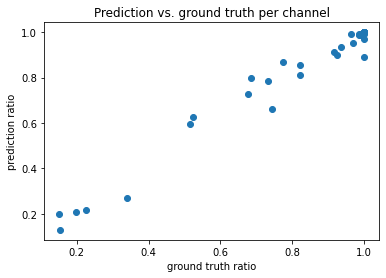

In [8]:
# plt.scatter(g.loc[(g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8), "cb_ratio"], g.loc[(g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8), "vh_ratio"], c="red")
# plt.scatter(g.loc[~((g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8)), "cb_ratio"], g.loc[~((g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8)), "vh_ratio"], c="blue")
plt.scatter(g["gt_ratio"], g["pred_ratio"])
plt.xlabel("ground truth ratio")
plt.ylabel("prediction ratio")
plt.title("Prediction vs. ground truth per channel")
plt.savefig(os.path.join(p_dir, "ground truth vs prediction_channel.jpg"))
plt.show()

In [79]:
tot2 = pd.concat([combo, combo2], axis=0)
tot2.shape

(10328, 18)

In [80]:
img_dir = "../images_medium"
tot2["qtl_o"] = tot2["qtl"]
tot2.loc[tot2["qtl"] == "high", "qtl"] = "very high"
tot2.loc[tot2["qtl"] == "low", "qtl"] = "very low"
tot2_gen = test_generator(tot2.loc[:, [c for c in tot2.columns if c != "qtl"]], tot2["qtl"], img_dir, cat_lbl)
y_tot2_prob = model.predict(tot2_gen, steps=tot2["qtl"].shape[0])
y_pred2 = np.argmax(y_tot2_prob, axis=1)
y_pred2 = pd.Series([cat_lbl[i] for i in y_pred2]).astype("category").cat.reorder_categories(cat_lbl)
tot2 = pd.concat([tot2.reset_index(drop=True), y_pred2.reset_index(drop=True)], axis=1)                        

In [81]:
# tot = pd.concat([train, val, test], axis=0)
tot2.rename(columns={0: "pred"}, inplace=True)
tot2.to_pickle(os.path.join(p_dir, "tot2.pkl"))
tot2.shape

(10328, 20)

In [12]:
tot2 = pd.read_pickle(os.path.join(p_dir, "tot2.pkl"))

In [13]:
tot2["gt"] = (tot2["qtl"] == "very high").astype(int)
tot2["pred"] = (tot2["pred"] == "very high").astype(int)
g2 = tot2.groupby(["channel_name"]).agg({"id_video": "count", "pred": "sum", "gt": "sum"}).reset_index()
g2.rename(columns={"id_video": "video_cnt", "pred": "pred_cnt", "gt": "gt_cnt"}, inplace=True)
g2["gt_ratio"] = g2["gt_cnt"] / g2["video_cnt"]
g2["pred_ratio"] = g2["pred_cnt"] / g2["video_cnt"]

In [14]:
tot2.head()

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,...,view_count_channel,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl,qtl_o,pred,gt
0,toVfvRhWbj8,How Does A Carburetor Work? | Transparent Carb...,UC6107grRI4m0o2-emgoDnAA,SmarterEveryDay,2021-06-30 16:01:11+00:00,308158.0,2265.0,6157911.0,6,98,...,974567798,2006-04-04 04:12:24+00:00,188,9980000.0,344,-0.482845,very high,very high,1,1
1,TCxoZlFqzwA,How Does Film ACTUALLY Work? (It's MAGIC) [Ph...,UC6107grRI4m0o2-emgoDnAA,SmarterEveryDay,2021-06-13 21:14:30+00:00,108396.0,1653.0,2494470.0,6,91,...,974567798,2006-04-04 04:12:24+00:00,188,9980000.0,344,-1.386507,very high,very high,1,1
2,MUaTOoVmg1Q,"Exploding Weed Seeds (28,546 fps Slow Motion)-...",UC6107grRI4m0o2-emgoDnAA,SmarterEveryDay,2021-05-30 14:00:14+00:00,132375.0,2270.0,2478806.0,7,68,...,974567798,2006-04-04 04:12:24+00:00,188,9980000.0,344,-1.392806,very high,very high,1,1
3,flmkQZvN_g8,What happens when 2 Weedeaters Hit Each Other?...,UC6107grRI4m0o2-emgoDnAA,SmarterEveryDay,2021-04-30 01:02:05+00:00,126450.0,2480.0,2911797.0,8,96,...,974567798,2006-04-04 04:12:24+00:00,188,9980000.0,344,-1.231813,very high,very high,1,1
4,g3Ud6mHdhlQ,How Do Nuclear Submarines Make Oxygen?- Smarte...,UC6107grRI4m0o2-emgoDnAA,SmarterEveryDay,2021-02-21 14:00:10+00:00,178969.0,2349.0,5016298.0,10,61,...,974567798,2006-04-04 04:12:24+00:00,188,9980000.0,344,-0.687891,very high,very high,1,1


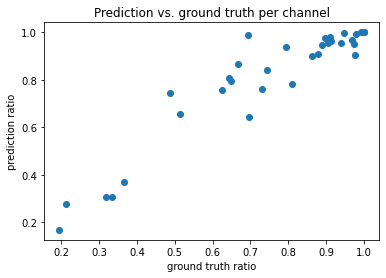

In [15]:
# plt.scatter(g.loc[(g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8), "cb_ratio"], g.loc[(g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8), "vh_ratio"], c="red")
# plt.scatter(g.loc[~((g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8)), "cb_ratio"], g.loc[~((g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8)), "vh_ratio"], c="blue")
plt.scatter(g2["gt_ratio"], g2["pred_ratio"])
plt.xlabel("ground truth ratio")
plt.ylabel("prediction ratio")
plt.title("Prediction vs. ground truth per channel")
plt.savefig(os.path.join(p_dir, "ground truth vs prediction_channel_w_middle.jpg"))
plt.show()

In [16]:
g2.sort_values(by=["gt_ratio"]).head()

,channel_name,video_cnt,pred_cnt,gt_cnt,gt_ratio,pred_ratio
27,The Royal Institution,930,156,181,0.194624,0.167742
9,Massachusetts Institute of Technology (MIT),589,164,125,0.212224,0.278438
26,The Planetary Society,337,103,107,0.317507,0.305638
3,CrashCourse,1333,408,444,0.333083,0.306077
24,StarTalk,631,232,230,0.364501,0.367670


In [17]:
cxy = g2.loc[g2.channel_name.isin(["Veritasium", "Physics Girl", "Primer", "3Blue1Brown", "CrashCourse"]), ["channel_name", "gt_ratio", "pred_ratio"]]
cxy["xo"] = -0.02
cxy["yo"] = 0.02
cxy["xto"] = -0.25
cxy["yto"] = -0.25
cxy["ha"] = "left"
cxy["va"] = "bottom"

cxy.loc[cxy["channel_name"] == "CrashCourse", "xo"] = 0.0
cxy.loc[cxy["channel_name"] == "CrashCourse", "yo"] = 0.02
cxy.loc[cxy["channel_name"] == "CrashCourse", "xto"] = 0.0
cxy.loc[cxy["channel_name"] == "CrashCourse", "yto"] = 0.1
cxy.loc[cxy["channel_name"] == "CrashCourse", "ha"] = "center"

cxy.loc[cxy["channel_name"] == "Veritasium", "xo"] = -0.02
cxy.loc[cxy["channel_name"] == "Veritasium", "yo"] = 0.0
cxy.loc[cxy["channel_name"] == "Veritasium", "xto"] = -0.1
cxy.loc[cxy["channel_name"] == "Veritasium", "yto"] = 0.03
cxy.loc[cxy["channel_name"] == "Veritasium", "ha"] = "right"

cxy.loc[cxy["channel_name"] == "Physics Girl", "xo"] = -0.02
cxy.loc[cxy["channel_name"] == "Physics Girl", "yo"] = 0.0
cxy.loc[cxy["channel_name"] == "Physics Girl", "xto"] = -0.1
cxy.loc[cxy["channel_name"] == "Physics Girl", "yto"] = 0.03
cxy.loc[cxy["channel_name"] == "Physics Girl", "ha"] = "right"

cxy.loc[cxy["channel_name"] == "Primer", "xo"] = -0.02
cxy.loc[cxy["channel_name"] == "Primer", "yo"] = 0.01
cxy.loc[cxy["channel_name"] == "Primer", "xto"] = -0.2
cxy.loc[cxy["channel_name"] == "Primer", "yto"] = 0.01
cxy.loc[cxy["channel_name"] == "Primer", "ha"] = "right"

cxy.loc[cxy["channel_name"] == "3Blue1Brown", "xo"] = -0.02
cxy.loc[cxy["channel_name"] == "3Blue1Brown", "yo"] = -0.01
cxy.loc[cxy["channel_name"] == "3Blue1Brown", "xto"] = -0.1
cxy.loc[cxy["channel_name"] == "3Blue1Brown", "yto"] = -0.02
cxy.loc[cxy["channel_name"] == "3Blue1Brown", "ha"] = "right"

cxy.head()

,channel_name,gt_ratio,pred_ratio,xo,yo,xto,yto,ha,va
0,3Blue1Brown,0.939130,0.956522,-0.02,-0.01,-0.1,-0.02,right,bottom
3,CrashCourse,0.333083,0.306077,0.00,0.02,0.0,0.10,center,bottom
16,Physics Girl,0.808743,0.781421,-0.02,0.00,-0.1,0.03,right,bottom
17,Primer,1.000000,1.000000,-0.02,0.01,-0.2,0.01,right,bottom
29,Veritasium,0.731250,0.762500,-0.02,0.00,-0.1,0.03,right,bottom


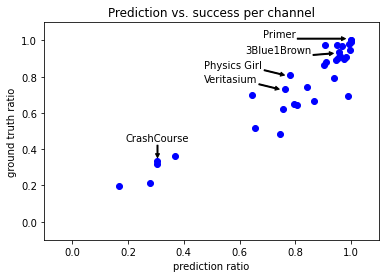

In [18]:
# plt.scatter(g.loc[(g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8), "cb_ratio"], g.loc[(g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8), "vh_ratio"], c="red")
# plt.scatter(g.loc[~((g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8)), "cb_ratio"], g.loc[~((g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8)), "vh_ratio"], c="blue")
plt.scatter(g2["pred_ratio"], g2["gt_ratio"], c="blue")
plt.xlabel("prediction ratio")
plt.ylabel("ground truth ratio")
plt.ylim(-0.1, 1.1)
plt.xlim(-0.1, 1.1)
plt.title("Prediction vs. success per channel")

for i, row in cxy.iterrows():
    plt.annotate(row["channel_name"], xy=(row["pred_ratio"] + row["xo"], row["gt_ratio"] + row["yo"]), 
                 xytext=(row["pred_ratio"] + row["xto"], row["gt_ratio"] + row["yto"]),
                 arrowprops=dict(facecolor="black", headwidth=4, width=1, headlength=4), 
                 horizontalalignment=row["ha"], 
                 verticalalignment=row["va"])

plt.savefig(os.path.join(p_dir, "ground truth vs prediction_channel_w_middle_v2.jpg"))
plt.show()

# Test model on the out of sample channels

In [248]:
cat_lbl = ["very low", "very high"]
combo_excl1 = combo_excl.loc[combo_excl.qtl.isin(cat_lbl), :]
combo_excl2 = combo_excl.loc[~combo_excl.qtl.isin(cat_lbl), :]
combo_excl1.qtl = combo_excl1.qtl.cat.remove_unused_categories()

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [249]:
combo_excl1.head()

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,id_channel,view_count_channel,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl
345,R3l1xYgQXpI,Sniffing Out a Seabird in the Desert,UCZYTClx2T1of7BRZ86-8fow,SciShow,2021-09-06 21:00:07+00:00,3885.0,41.0,65075.0,3,36,UCZYTClx2T1of7BRZ86-8fow,1427641483,2011-10-20 16:11:13+00:00,122,6760000.0,2756,-4.643238,very low
349,MRoCsb9qcyQ,Will We Ever be Able to Predict Earthquakes?,UCZYTClx2T1of7BRZ86-8fow,SciShow,2021-09-01 21:00:06+00:00,4682.0,163.0,105121.0,3,44,UCZYTClx2T1of7BRZ86-8fow,1427641483,2011-10-20 16:11:13+00:00,122,6760000.0,2756,-4.163666,very low
350,C_A77UKZBUY,These Glaciers Cannot Melt,UCZYTClx2T1of7BRZ86-8fow,SciShow,2021-08-31 21:00:05+00:00,7970.0,85.0,156752.0,4,26,UCZYTClx2T1of7BRZ86-8fow,1427641483,2011-10-20 16:11:13+00:00,122,6760000.0,2756,-3.764113,very low
352,AH8vF6yReIQ,Seven Ways Poop Saves Lives,UCZYTClx2T1of7BRZ86-8fow,SciShow,2021-08-30 15:25:45+00:00,5459.0,195.0,161726.0,4,27,UCZYTClx2T1of7BRZ86-8fow,1427641483,2011-10-20 16:11:13+00:00,122,6760000.0,2756,-3.732875,very low
355,iX_oY2mDY7k,The Speedy Cold-Hearted Tuna,UCZYTClx2T1of7BRZ86-8fow,SciShow,2021-08-24 22:54:58+00:00,8337.0,96.0,164683.0,4,28,UCZYTClx2T1of7BRZ86-8fow,1427641483,2011-10-20 16:11:13+00:00,122,6760000.0,2756,-3.714756,very low


In [250]:
img_dir = "../images_medium"

test_gen = test_generator(combo_excl1.loc[:, [c for c in combo_excl1.columns if c != "qtl"]], combo_excl1["qtl"], img_dir, cat_lbl)
y_oos_prob = model.predict(test_gen, steps=combo_excl1["qtl"].shape[0])
y_pred = np.argmax(y_oos_prob, axis=1)
y_pred = pd.Series([cat_lbl[i] for i in y_pred]).astype("category").cat.reorder_categories(cat_lbl)

In [251]:
lb = mybinarizer()
y_test_no = lb.transform(combo_excl1["qtl"], cat_lbl)[:, 1]
y_pred_no = y_oos_prob[:,  1]
fpr, tpr, thr = roc_curve(y_test_no, y_pred_no)

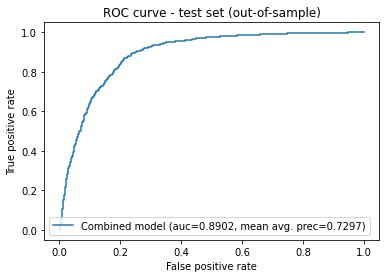

In [252]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_test_no, y_pred_no)

# plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Combined model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
df_roc = pd.DataFrame({"fpr": fpr, "tpr": tpr})
df_roc.to_pickle("../roc_combo.pkl")
d_roc = pd.DataFrame({"auc": [auc_model], "mavgp": [mavgp]})
d_roc.to_pickle("../d_combo.pkl")

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - test set (out-of-sample)")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve.jpg"))
plt.show()

In [256]:
img_dir = "../images_medium"

combo_excl2.loc[combo_excl2["qtl"] == "high", "qtl"] == "very high"
combo_excl2.loc[combo_excl2["qtl"] == "low", "qtl"] == "very low"

test_gen = test_generator(combo_excl2.loc[:, [c for c in combo_excl2.columns if c != "qtl"]], combo_excl2["qtl"], img_dir, cat_lbl)
y_oos2_prob = model.predict(test_gen, steps=combo_excl2["qtl"].shape[0])
y_pred = np.argmax(y_oos_prob, axis=1)
y_pred = pd.Series([cat_lbl[i] for i in y_pred]).astype("category").cat.reorder_categories(cat_lbl)

In [257]:
lb = mybinarizer()
y_test_no = lb.transform(combo_excl2["qtl"], cat_lbl)[:, 1]
y_pred_no = y_oos2_prob[:,  1]
fpr, tpr, thr = roc_curve(y_test_no, y_pred_no)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


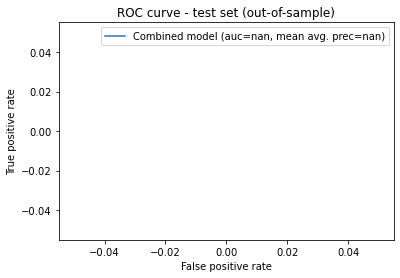

In [258]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_test_no, y_pred_no)

# plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Combined model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
df_roc = pd.DataFrame({"fpr": fpr, "tpr": tpr})
df_roc.to_pickle("../roc_combo.pkl")
d_roc = pd.DataFrame({"auc": [auc_model], "mavgp": [mavgp]})
d_roc.to_pickle("../d_combo.pkl")

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - test set (out-of-sample)")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve.jpg"))
plt.show()

In [60]:
tot.loc[(tot["pred"] == "very low") & (tot["qtl"] == "very low") , ["id_video", "title", "channel_name", "ln_vc_norm", "qtl", "pred", "subscriber_count", "view_count_video"]].sort_values(by=["ln_vc_norm"], ascending=False).head(10)

,id_video,title,channel_name,ln_vc_norm,qtl,pred,subscriber_count,view_count_video
3577,fOvTtapxa9c,Natural Language Processing: Crash Course Comp...,CrashCourse,-3.555269,very low,very low,12700000.0,362886.0
2026,AaZ4h-zKggg,"I'm Peter Hicks, and I've worked at MIT for 47...",Massachusetts Institute of Technology (MIT),-3.555721,very low,very low,724000.0,20678.0
4709,Rrle0mD92WU,Why Emotional Tears Are Different,AsapSCIENCE,-3.555814,very low,very low,9740000.0,278156.0
5363,muE1wPzr398,Copper Sulfate Colour Change (reaction only),Periodic Videos,-3.556260,very low,very low,1520000.0,43389.0
4627,ydMUVl3jpiU,StarTalk Live! at SF Sketchfest (Full Show Par...,StarTalk,-3.559855,very low,very low,1560000.0,44371.0
147,V_2YJr02-f0,Art with Bullets,SmarterEveryDay,-3.560136,very low,very low,9980000.0,283781.0
4286,rLB_iHmFSeU,Making a Mini Sun in a Microwave! Microwaving ...,The Action Lab,-3.561897,very low,very low,3580000.0,101618.0
2123,wmFtUe9HzdA,Watching tumors burst through a blood vessel,Massachusetts Institute of Technology (MIT),-3.562174,very low,very low,724000.0,20545.0
1588,qUNzoa991g4,"Drugs, science and society; past, present and ...",The Royal Institution,-3.562947,very low,very low,1070000.0,30340.0
3553,dhgEpr87Yac,"Liberals, Conservatives, and Pride and Prejudi...",CrashCourse,-3.565030,very low,very low,12700000.0,359361.0


In [86]:
# foo = pd.concat([x_train2, x_val2, x_test2], axis=0)
# poo = pd.concat([y_train2, y_val2, y_test2], axis=0)
combo3 = pd.concat([x_test2.reset_index(drop=True), y_test2.reset_index(drop=True), y_pred2], axis=1)
combo3.rename(columns={0: "pred"}, inplace=True)
combo3.head()

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,id_channel,view_count_channel,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl,pred
0,s94suB5uLWw,Magnetism: Crash Course Physics #32,UCX6b17PVsYBQ0ip5gyeme-Q,CrashCourse,2016-12-01 22:00:03+00:00,16909.0,798.0,1280367.0,60,35,UCX6b17PVsYBQ0ip5gyeme-Q,1546387741,2006-05-20 02:43:42+00:00,187,12700000.0,1334,-2.294455,high,very low
1,4mWxL8upOPo,Dangerous Marshmallows?!,UCeiYXex_fwgYDonaTcSIk6w,MinuteEarth,2020-11-19 22:41:50+00:00,15311.0,190.0,400818.0,13,24,UCeiYXex_fwgYDonaTcSIk6w,363864862,2011-10-20 02:21:51+00:00,122,2600000.0,266,-1.869759,high,very high
2,cKymBcFf3wc,Origin Of Bathroom Stuff -- Thought Glass #5,UCqmugCqELzhIMNYnsjScXXw,Vsauce2,2014-07-17 17:08:29+00:00,16469.0,321.0,808196.0,89,44,UCqmugCqELzhIMNYnsjScXXw,671152937,2010-12-07 16:43:13+00:00,132,4370000.0,393,-1.687714,high,very high
3,TI4XanbrteU,Alex (French Guy Cooking) and Neil deGrasse Ty...,UCqoAEDirJPjEUFcF2FklnBA,StarTalk,2019-08-12 14:00:04+00:00,2867.0,52.0,70388.0,28,66,UCqoAEDirJPjEUFcF2FklnBA,115816413,2010-12-22 22:12:53+00:00,132,1560000.0,631,-3.098418,low,very high
4,n2RhC4JNS7M,My Path into Physics (at MIT),UC7DdEm33SyaTDtWYGO2CwdA,Physics Girl,2017-09-21 18:19:12+00:00,14524.0,326.0,435494.0,51,29,UC7DdEm33SyaTDtWYGO2CwdA,148707406,2011-10-21 15:36:08+00:00,122,2050000.0,183,-1.549114,high,very high


In [89]:
combo3.loc[(combo3["pred"] == "very high") & (combo3["qtl"] == "high") , ["id_video", "title", "channel_name", "ln_vc_norm", "qtl", "pred", "subscriber_count", "view_count_video"]].sort_values(by=["ln_vc_norm"], ascending=False).head(10)

,id_video,title,channel_name,ln_vc_norm,qtl,pred,subscriber_count,view_count_video
17,5fXmvMhwBWc,Turn Music into Shapes!,D!NG,-1.437928,high,very high,1830000.0,434477.0
318,wIgd9C7NgcA,Neptune - Sixty Symbols,Sixty Symbols,-1.439389,high,very high,840000.0,199141.0
704,mzEOL-N2cbw,Sodium v Water (slow motion) - Periodic Table ...,Periodic Videos,-1.443762,high,very high,1520000.0,358778.0
689,s4XQo4txlk0,How Much Pain Can You Handle? (The LAB),AsapSCIENCE,-1.447375,high,very high,9740000.0,2290719.0
266,R9Plq-D1gEk,Inventing Game of Life (John Conway) - Numberp...,Numberphile,-1.448926,high,very high,3890000.0,913459.0
817,kvARvzMErnk,Sandwich Bag Fire Starter,Veritasium,-1.451395,high,very high,10000000.0,2342433.0
698,Af3ZG47oT7I,What is Cool?,Vsauce,-1.453969,high,very high,17100000.0,3995264.0
128,nDSNS553WaE,Space Robots in Antarctica - How scientists pl...,The Planetary Society,-1.457524,high,very high,69700.0,16227.0
407,MHXO86wKeDY,The simpler quadratic formula | Lockdown math ...,3Blue1Brown,-1.458254,high,very high,3910000.0,909631.0
356,kexteGM2V2s,Exploding Wires,Periodic Videos,-1.458370,high,very high,1520000.0,353575.0


In [102]:
vids = ["uNOKWoDtbSk", "uxPdPpi5W4o", "Uw42xyb5wz8", "UxbeLdXnaGU", "s4XQo4txlk0"]

In [103]:
foo = pd.concat([tot.reset_index(drop=True), combo3.reset_index(drop=True)], axis=0)
foo.loc[foo["id_video"].isin(vids) , ["id_video", "title", "channel_name", "ln_vc_norm", "qtl", "pred", "subscriber_count", "view_count_video"]].sort_values(by=["ln_vc_norm"], ascending=False).head(10)
# foo.head()

,id_video,title,channel_name,ln_vc_norm,qtl,pred,subscriber_count,view_count_video
442,uxPdPpi5W4o,"Why Are 96,000,000 Black Balls on This Reservoir?",Veritasium,2.009282,very high,very high,10000000.0,74579580.0
3165,uNOKWoDtbSk,Does this look white to you?,Physics Girl,1.430654,very high,very high,2050000.0,8571941.0
689,s4XQo4txlk0,How Much Pain Can You Handle? (The LAB),AsapSCIENCE,-1.447375,high,very high,9740000.0,2290719.0
597,UxbeLdXnaGU,Galileo the Scientific Parrot,Veritasium,-3.521942,low,very low,10000000.0,295420.0
3215,Uw42xyb5wz8,Announcing the Crash Course Coins,CrashCourse,-5.278391,very low,very low,12700000.0,64778.0


In [101]:
foo.loc[foo["title"].str.startswith("Announcing") , ["id_video", "title", "channel_name", "ln_vc_norm", "qtl", "pred", "subscriber_count", "view_count_video"]].sort_values(by=["ln_vc_norm"], ascending=False).head(10)

,id_video,title,channel_name,ln_vc_norm,qtl,pred,subscriber_count,view_count_video
3303,JfMmzx67Krw,Announcing the Crash Course App!,CrashCourse,-4.351872,very low,very low,12700000.0,163610.0
38,UXq1VFWTQE0,Announcing ThinkerCon! - A Celebration of Onli...,SmarterEveryDay,-4.475206,very low,very low,9980000.0,113651.0
3215,Uw42xyb5wz8,Announcing the Crash Course Coins,CrashCourse,-5.278391,very low,very low,12700000.0,64778.0


# Bilder für Paper

In [95]:
tot_ok = tot2.loc[tot2["qtl_o"].isin(["very low", "low"]) & (tot2["pred"] == "very low"), ["channel_name", "title", "qtl_o", "pred", "ln_vc_norm"]]
tot_ok.loc[(tot_ok["qtl_o"] == "very low") , :].sort_values("ln_vc_norm", ascending=True).head()

,channel_name,title,qtl_o,pred,ln_vc_norm
1979,Massachusetts Institute of Technology (MIT),MIT China Summit: Richard Lester,very low,very low,-7.924202
1971,Massachusetts Institute of Technology (MIT),MIT China Summit: Melissa Nobles,very low,very low,-7.901560
1969,Massachusetts Institute of Technology (MIT),MIT China Summit: Martin A. Schmidt,very low,very low,-7.840057
1712,The Royal Institution,Christmas Lectures 2011 - Video Blog 4,very low,very low,-7.771702
183,SmarterEveryDay,Crafts in Peru,very low,very low,-7.747400


In [100]:
tot_nok = tot2.loc[tot2["qtl_o"].isin(["very low", "low"]) & (tot2["pred"] != "very low"), ["channel_name", "title", "qtl_o", "pred", "ln_vc_norm"]]
tot_nok.loc[(tot_nok["qtl_o"] == "very low") , :].sort_values("ln_vc_norm", ascending=True).head(10)

,channel_name,title,qtl_o,pred,ln_vc_norm
5088,Numberphile,Why do YouTube views freeze at 301?,very low,very high,-9.466809
4384,The Action Lab,Hydraulic Press vs. My New Science Channel!,very low,very high,-7.564156
175,SmarterEveryDay,At the Beach! (Great Clouds),very low,very high,-7.546308
184,SmarterEveryDay,Beautiful scenery in Peru,very low,very high,-7.457227
4404,The Action Lab,Wooden 2X4s crushed to SPLINTERS by HYDRAULIC ...,very low,very high,-7.122554
4409,The Action Lab,Hydraulic Press| SHOT GLASS Explodes! A GOLF B...,very low,very high,-7.092874
2248,Massachusetts Institute of Technology (MIT),Mattress dominos,very low,very high,-6.752027
179,SmarterEveryDay,Balloons on the River - (Decatur - Sufjan Stev...,very low,very high,-6.355149
1726,The Royal Institution,Ri Channel Ident,very low,very high,-6.354837
4391,The Action Lab,Bread Loaf Crushed by Hydraulic Press | How To...,very low,very high,-6.087680


In [107]:
t_ok = [
    "World's Roundest Object!",
    "How to See Without Glasses",
    "Navy SEAL Astronauts - Smarter Every Day 243",
    "Professor Look-Alikes - Periodic Table of Videos",
    "MIT China Summit: Martin A. Schmidt"
]

t_nok = [
    "MIT cheetah robot lands the running jump",
    "Experiment: Coca Cola and Milk",
    "Looking for Lisa Holst (Re: 10 Misconceptions Rundown)",
    "Stoned Girl Tries To Explain the Digestive System | STONED SCIENCE",
    "Hydraulic Press vs. My New Science Channel!"
]

p = tot2.loc[tot2["title"].isin(t_ok + t_nok), ["id_video", "channel_name", "title", "qtl_o", "pred"]]
p.head(10)

,id_video,channel_name,title,qtl_o,pred
242,aKPoQYevoLs,Home Science,Experiment: Coca Cola and Milk,very high,very low
526,ZMByI4s-D-Y,Veritasium,World's Roundest Object!,very high,very high
1969,hbvB_kC9JcU,Massachusetts Institute of Technology (MIT),MIT China Summit: Martin A. Schmidt,very low,very low
2077,_luhn7TLfWU,Massachusetts Institute of Technology (MIT),MIT cheetah robot lands the running jump,very high,very low
4384,_LgxHTv5zJg,The Action Lab,Hydraulic Press vs. My New Science Channel!,very low,very high
5167,OydqR_7_DjI,minutephysics,How to See Without Glasses,very high,very high
5602,QlTf5X0MKbg,SmarterEveryDay,Navy SEAL Astronauts - Smarter Every Day 243,high,very high
5775,NVmnLaTXylc,CGP Grey,Looking for Lisa Holst (Re: 10 Misconceptions ...,high,very low
9162,7HH7uCfBw0k,AsapSCIENCE,Stoned Girl Tries To Explain the Digestive Sys...,low,very high
10191,K_5wK95Nvk8,Periodic Videos,Professor Look-Alikes - Periodic Table of Videos,low,very low


## Info für zwei Intro Images

In [22]:
tot2.loc[tot2["title"].isin(["Does this look white to you?", "Announcing the Crash Course Coins"]), :].head()

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,...,view_count_channel,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl,qtl_o,pred,gt
3165,uNOKWoDtbSk,Does this look white to you?,UC7DdEm33SyaTDtWYGO2CwdA,Physics Girl,2015-10-06 16:53:56+00:00,128075.0,5017.0,8571941.0,74,28,...,148707406,2011-10-21 15:36:08+00:00,122,2050000.0,183,1.430654,very high,very high,1,1
3215,Uw42xyb5wz8,Announcing the Crash Course Coins,UCX6b17PVsYBQ0ip5gyeme-Q,CrashCourse,2021-06-14 17:03:42+00:00,4392.0,103.0,64778.0,6,33,...,1546387741,2006-05-20 02:43:42+00:00,187,12700000.0,1334,-5.278391,very low,very low,0,0


## Sample Bilder für Channels ohne Clickbait

In [50]:
tot2.loc[tot2["channel_name"].isin(["Physics Videos by Eugene Khutoryansky"]), :].head()

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,...,view_count_channel,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl,qtl_o,pred,gt
